# 文本预处理

文本的常见预处理步骤
- 将文本作为字符串加载到内存中
- 将字符串拆分为词元（如单词和字符）
- 建立一个词表，将拆分的词元映射到数字索引
- 将文本转换为数字索引序列，方便模型操作

总结：
- 文本是序列数据的一种常见的形式之一
- 为了对文本进行预处理，通常将文本拆分为词元，**构建词表**将词元字符串映射为数字索引，并将**文本数据转为词元素索引**以供模型操作

## 代码

In [ ]:
!pip install d2l

**`re`包**：正则表达式模块，用于处理字符串匹配和操作，特别是查找、替换、分割等操作

In [ ]:
import collections
import re

from d2l import torch as d2l

### 读取数据集

**将数据集读取到由多条文本行组成的列表中**
- `re.sub(pattern, repl, string)`用于通过正则表达式替换字符串中的匹配内容
  - `pattern`正则表达式，定义要匹配的模式
  - `repl`用来替换匹配内容的字符串或函数
  - `string`要处理的目标字符串
- [^A-Za-z]+`
  - `^`表示取反
  - `[A-Za-z]`匹配大写和小写英文字母
  - `+`匹配前面的模式一次或多次
- `strip()`移除首尾空格
- `lower()`转换为小写

In [ ]:
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt', '090b5e7e70c295757f55df93cb0a180b9691891a')

# 暴力预处理
def read_time_machine():
  with open(d2l.download('time_machine', 'r')) as f:
    lines = f.readlines()
  return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'文本总行数：{len(lines)}')
print(lines[0])
print(lines[10])

文本总行数：3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


### 词元化

`tokenize`将文本行列表（`lines`）作为输入，列表中的每个元素是一个文本序列
- 再**将每个文本序列拆分为一个词元列表**

In [ ]:
def tokenize(lines, token='word'):
  if token == 'word':
    return [line.split() for line in lines]
  elif token == 'char':
    return [list(line) for line in lines]
  else:
    print('error:unkown type' + token)

tokens = tokenize(lines)
for i in range(11):
  print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


### 词表

（词元的类型是字符串，而模型需要的输入是数字，故这种类型不方便模型使用）  
**构建一个字典（词表vocabulary），用来将字符串类型的词元映射到从0开始的数字索引中**
- 将训练集中所有文档合并，对唯一词元进行统计，得到的称之为**语料**（corpus）
- 根据每个唯一词元出现的频率，为其分配一个**数字索引**
- 很少出现的词元通常被**移除**，降低复杂度
- 语料库中不存在或已删除的任何词元都将映射到一个特定的未知词元**“<unk>”**
- 可以选择增加一个列表（保留词元列表），用于保存那些被保留的词元
  -  例如：填充词元（`<pad>`）； 序列开始词元（`<bos>`）； 序列结束词元（`<eos>`）
  - 会被添加到词表中，紧跟在`<unk>`后面

- **`collections.Counter`**是`collectinos`模块中的一个子类
  - 用于**统计可迭代对象中元素的出现次数**，类似一个**字典**
- `counter.items()`返回一个由键值对组成的可迭代对象

- `idx_to_token`是一个列表，用于*从索引查找词元*
- `token_to_idx`是一个字典，用于*从词元查找索引*
- `dict.get(key, default=None)`
  - `key`要查找的键
  - `default`如果键不存在时，返回的默认值
- `@property`是一个装饰器
  - 用来将类的方法定义为**只读属性**
  - 可以像访问属性一样调用，**不需要**在后面加括号`()`

**注意（重要！！）**：
- 当对一个对象**调用`len()`**时，实际上是调用了该对象的`__len__()`方法
  - 如果类中定义了`__len__()`方法，`len()`就会使用这个方法返回对象的长度
- 调用`__getitem__`方法的标准方式是使用**方括号访问对象的元素**
  - 使用**`obj[key]`**的形式
- 调用`__call__`方法，使用 **加粗文字**小括号访问
  - 使用**`obj(key)`**的形式

In [ ]:
class Vocab():
  def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
    if tokens is None:
      tokens = []
    if reserved_tokens is None:
      reserved_tokens = []
    counter = count_corpus(tokens)
    self._token_freqs = sorted(counter.items(), key=lambda x:x[1], reverse=True)
    # 初始化一个词表中从索引到词元的映射
    # 将特殊的未知词元(<unk>)作为词表中的第一个词元，同时添加保留的特殊词元(reserved_tokens)
    self.idx_to_token = ['<unk>'] + reserved_tokens
    self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
    for token, freq in self._token_freqs:
      if freq < min_freq:
        break
      if token not in self.token_to_idx:  # 新添加词
        self.idx_to_token.append(token)
        self.token_to_idx[token] = len(self.idx_to_token) - 1

  def __len__(self):
    return len(self.idx_to_token)

  # 根据给定的词元或词元列表，返回对应的索引或索引列表
  def __getitem__(self, tokens):
    # 单个词元
    if not isinstance(tokens, (tuple, list)):
      return self.token_to_idx.get(tokens, self.unk)
    return [self.__getitem__(token) for token in tokens]

  def to_tokens(self, indices):
    if not isinstance(indices, (list, tuple)):
      return self.idx_to_tokens[indices]
    return [self.idx_to_tokens[indice] for indice in indices]

  @property
  def unk(self):  # 未知词元的索引为0
    return 0

  @property
  def token_freqs(self):
    return self._token_freqs


def count_corpus(tokens):
  if len(tokens) == 0 or isinstance(tokens[0], list):
    # 将词元列表展平为一个列表
    tokens = [token for line in tokens for token in line]
  return collections.Counter(tokens)

使用time_mechine数据集作为语料库来**构建词表**，打印前几个高频词元及其索引

In [ ]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


**将每一条文本行转换为一个数字索引列表**

In [ ]:
for i in (0, 10):
  print('文本：', tokens[i])
  print('索引：', vocab[tokens[i]])

文本： ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
索引： [1, 19, 50, 40, 2183, 2184, 400]
文本： ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
索引： [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


### 整合所有功能

**将所有功能打包到`load_corpus_time_machine`函数中**
- 函数返回`corpus`（词元索引列表）和`vocab`（时光机器与语料库的词表）
- 改变
  - 为了简化后面章节中的训练，使用**字符**实现文本词元化
  - time_machine数据集中每个文本行不一定是一个句子或一个段落，可能是一个单词，因此返回的`corpus`仅处理为**单个列表**，而不是使用多词元列表构成的一个列表

- `corpus`是一个由索引组成的一维列表，表示将原始文本数据逐字符映射为数字后的结果
- `vocab`每个字符通过其映射到唯一索引

In [ ]:
def load_corpus_time_machine(max_tokens=-1):
  lines = read_time_machine()
  tokens = tokenize(lines, 'char')
  vocab = Vocab(tokens)
  corpus = [vocab[token] for line in tokens for token in line]
  if max_tokens > 0:
    corpus = corpus[:max_tokens]
  return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(170580, 28)

## 练习

### 1
1. 词元化是一个关键的预处理步骤，它因语言而异。尝试找到另外三种常用的词元化文本的方法。

- BPE(Byte-Pair Encoding)：基于合并规则的子词分解方法
  - 工作原理
    - 初始化：将文本数据中的每个单词拆分为最小的字符单元，并将这些字符作为初始词汇表
    - 统计频率：统计当前词汇表中相邻的字符或子词对的出现频率
    - 合并最高频率的子词对：将出翔次数最多的相邻字符对（或子词对）合并为一个新词，并更新词汇表
    - 重复：不断合并，直到达到指定的词汇表大小或满足某中条件
  - 缺点
    - 需要预先统计合并规则，训练成本相对较高
    - 合并规则的结果依赖于训练数据，跨领域效果可能有所下降
- WordPiece：广泛应用于Transformer架构，也是一种基于子词的分解方法，但合并规则有所不同
  - 工作原理
    - 初始化：将文本数据中的每个单词拆分为最小的字符单元
    - 统计频率：统计当前子词序列的概率，概率是基于文本数据中序列的预言模型得到的
    - 合并最高概率的子词对：WordPiece 使用的是**最大似然估计**来决定合并规则，而不是简单的频率统计
    - 重复：重复合并，直到达到目标词汇表大小
- SentencePiece：一种通用的文本分词工具，能够对任何语言进行无监督分词
  - 不需要依赖空格等语言特定的边界标记
  - 工作原理
    - 输入文本：将整个文本视为字符串（不是逐词处理），并对其进行编码
    - 基于BPE或Unigram：支持多种分词算法（如 BPE 和 Unigram），通过统计分析或概率建模生成子词分解规则
    - 生成子词表：通过反复训练，生成一个包含固定大小子词的词汇表
    - 分词：将输入文本分解为子词序列，通常加入特殊标记（如`▁`）以标识词语边界
  - 优点
    - 无需预处理，直接处理原始文本

- 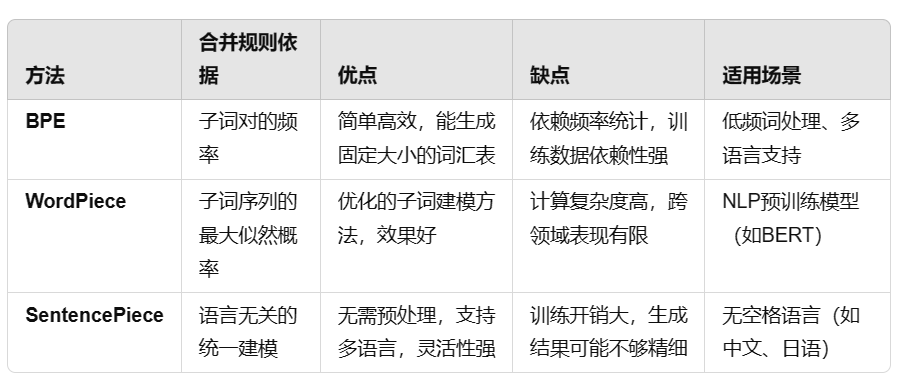

### 2
2. 在本节的实验中，将文本词元为单词和更改`Vocab`实例的`min_freq`参数，这对词表大小有何影响？

In [ ]:
!pip install d2l

In [ ]:
import collections
import re
import numpy as np

from d2l import torch as d2l

In [ ]:
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt', '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():
  with open (d2l.download('time_machine'), 'r') as f:
    lines = f.readlines()
  return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

def tokenize(lines, token='word'):
  if token == 'word':
    return [line.split() for line in lines]
  if token == 'char':
    return [list(line) for line in lines]
  else:
    print('error:unkown type ' + token)

class Vocab:
  def __init__(self, tokens, min_freq=0, reserved_tokens=None):
    if tokens is None:
      tokens = []
    if reserved_tokens is None :
      reserved_tokens = []
    counter = count_corpus(tokens)
    self._token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
    self.idx_to_token = ['<unk>'] + reserved_tokens
    self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
    for token, freq in self._token_freqs:
      if freq < min_freq:
        break
      if token not in self.idx_to_token:
        self.idx_to_token.append(token)
        self.token_to_idx[token] = len(self.idx_to_token) - 1

  def __len__(self):
    return len(self.idx_to_token)

  def __getitem__(self, tokens):
    if not isinstance(tokens, (tuple, list)):
      return self.token_to_idx.get(tokens, self.unk)
    return [self.__getitem__(token) for token in tokens]

  def to_tokens(self, indices):
    if not isinstance(indices, (tuple, list)):
      return self.idx_to_tokens[indices]
    return [self.idx_to_tokens[indice] for indice in indices]

  @property
  def unk(self):
    return 0

  @property
  def token_freqs(self):
    return self._token_freqs

def count_corpus(tokens):
  if len(tokens) == 0 or isinstance(tokens[0], list):
    # 将词元展平为列表
    tokens = [token for line in tokens for token in line]
  return collections.Counter(tokens)

词元设置为`word`时，输出的语料库和词表大小

In [ ]:
def load_corpus_time_machine(max_tokens=-1):
  lines = read_time_machine()
  tokens = tokenize(lines)
  vocab = Vocab(tokens)
  corpus = [vocab[token] for line in tokens for token in line]
  if max_tokens > 0:
    return corpus[:max_tokens]
  return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(32775, 4580)

词元设置为`char`，输出的语料库和词表的大小

In [ ]:
def load_corpus_time_machine(max_tokens=-1):
  lines = read_time_machine()
  tokens = tokenize(lines, 'char')
  vocab = Vocab(tokens)
  corpus = [vocab[token] for line in tokens for token in line]
  if max_tokens > 0:
    return corpus[:max_tokens]
  return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(170580, 28)

设置`min_freq=10`，过滤掉低频词，得到的词表的结果

In [ ]:
lines = read_time_machine()
tokens = tokenize(lines)
vocab = Vocab(tokens, min_freq=10)

for i in [0, 10]:
  print('文本：', tokens[i])
  print('索引：', vocab[tokens[i]])

文本： ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
索引： [1, 19, 50, 40, 0, 0, 0]
文本： ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
索引： [0, 3, 25, 0, 362, 113, 7, 0, 3, 0, 1]


In [ ]:
def load_corpus_time_machine(max_tokens=-1):
  lines = read_time_machine()
  tokens = tokenize(lines, 'word')
  vocab = Vocab(tokens, min_freq=10)
  corpus = [vocab[token] for line in tokens for token in line]
  if max_tokens > 0:
    return corpus[:max_tokens]
  return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(32775, 400)